In [19]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# gpu 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("./Data/emotion3.tsv", sep="\t")
null_idx = df[df["document"].isnull()].index
df.loc[null_idx]
train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)
print("중복 제거 전 학습 데이터셋: {}".format(len(train_data)))
print("중복 제거 전 테스트 데이터셋: {}".format(len(test_data)))

# 중복 데이터 제거
train_data = train_data.drop_duplicates(["document"])
test_data = test_data.drop_duplicates(["document"])

# 데이터셋 갯수 확인
print("중복 제거 후 학습 데이터셋: {}".format(len(train_data)))
print("중복 제거 후 테스트 데이터셋: {}".format(len(test_data)))
MODEL_NAME = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_train_sentences = tokenizer(
    list(train_data['document']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True,
)
tokenizer_test_sentences = tokenizer(
    list(test_data['document']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True,
)

class CurseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_label = train_data['label'].values
test_label = test_data['label'].values

train_dataset = CurseDataset(tokenizer_train_sentences, train_label)
test_dataset = CurseDataset(tokenizer_test_sentences, test_label)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7).to(device)

traning_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

class LogCallback(TrainerCallback):
    def on_train_epoch_end(self, args, state, control, **kwargs):
        train_loss_values.append(state.log_history[-1]["train_loss"])
        train_acc_values.append(state.log_history[-1]["train_accuracy"])
        val_loss_values.append(state.log_history[-1]["eval_loss"])
        val_acc_values.append(state.log_history[-1]["eval_accuracy"])

trainer = Trainer(
    model=model,
    args=traning_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[LogCallback()],
)

# 훈련 손실 및 정확도 그래프 그리기
train_loss_values = []
train_acc_values = []
val_loss_values = []
val_acc_values = []

def log_callback(step, logs):
    train_loss_values.append(logs.get("train_loss"))
    train_acc_values.append(logs.get("train_accuracy"))
    val_loss_values.append(logs.get("eval_loss"))
    val_acc_values.append(logs.get("eval_accuracy"))

중복 제거 전 학습 데이터셋: 64770
중복 제거 전 테스트 데이터셋: 16193
중복 제거 후 학습 데이터셋: 59709
중복 제거 후 테스트 데이터셋: 15350


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
trainer.train()

  0%|          | 0/18660 [00:00<?, ?it/s]

C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 1.6031, 'grad_norm': 7.632872581481934, 'learning_rate': 5e-05, 'epoch': 0.27}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 1.0331, 'grad_norm': 7.643521785736084, 'learning_rate': 4.862334801762114e-05, 'epoch': 0.54}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.8893, 'grad_norm': 8.588146209716797, 'learning_rate': 4.7246696035242295e-05, 'epoch': 0.8}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.8015, 'grad_norm': 11.804886817932129, 'learning_rate': 4.5870044052863435e-05, 'epoch': 1.07}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.6642, 'grad_norm': 5.024416446685791, 'learning_rate': 4.449339207048459e-05, 'epoch': 1.34}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.6644, 'grad_norm': 7.93439245223999, 'learning_rate': 4.311674008810573e-05, 'epoch': 1.61}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.6558, 'grad_norm': 4.738731861114502, 'learning_rate': 4.1740088105726874e-05, 'epoch': 1.88}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.5432, 'grad_norm': 9.378602027893066, 'learning_rate': 4.036343612334802e-05, 'epoch': 2.14}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.4453, 'grad_norm': 9.513084411621094, 'learning_rate': 3.898678414096916e-05, 'epoch': 2.41}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.459, 'grad_norm': 7.3465070724487305, 'learning_rate': 3.761013215859031e-05, 'epoch': 2.68}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.468, 'grad_norm': 5.7838616371154785, 'learning_rate': 3.623348017621145e-05, 'epoch': 2.95}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.319, 'grad_norm': 11.970169067382812, 'learning_rate': 3.4856828193832605e-05, 'epoch': 3.22}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.309, 'grad_norm': 5.846876621246338, 'learning_rate': 3.3480176211453745e-05, 'epoch': 3.48}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3006, 'grad_norm': 9.576818466186523, 'learning_rate': 3.210352422907489e-05, 'epoch': 3.75}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2965, 'grad_norm': 5.654765605926514, 'learning_rate': 3.072687224669604e-05, 'epoch': 4.02}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1867, 'grad_norm': 9.607742309570312, 'learning_rate': 2.935022026431718e-05, 'epoch': 4.29}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1906, 'grad_norm': 11.23072338104248, 'learning_rate': 2.7973568281938327e-05, 'epoch': 4.56}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1975, 'grad_norm': 12.595696449279785, 'learning_rate': 2.659691629955947e-05, 'epoch': 4.82}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.18, 'grad_norm': 7.982532024383545, 'learning_rate': 2.522026431718062e-05, 'epoch': 5.09}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1248, 'grad_norm': 6.26862907409668, 'learning_rate': 2.3843612334801762e-05, 'epoch': 5.36}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1321, 'grad_norm': 0.18233928084373474, 'learning_rate': 2.246696035242291e-05, 'epoch': 5.63}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.133, 'grad_norm': 4.263833045959473, 'learning_rate': 2.1090308370044055e-05, 'epoch': 5.89}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1035, 'grad_norm': 6.154706001281738, 'learning_rate': 1.97136563876652e-05, 'epoch': 6.16}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0866, 'grad_norm': 15.848109245300293, 'learning_rate': 1.8337004405286344e-05, 'epoch': 6.43}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0925, 'grad_norm': 2.198878526687622, 'learning_rate': 1.696035242290749e-05, 'epoch': 6.7}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0962, 'grad_norm': 0.05520634353160858, 'learning_rate': 1.5583700440528634e-05, 'epoch': 6.97}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0614, 'grad_norm': 0.08202322572469711, 'learning_rate': 1.420704845814978e-05, 'epoch': 7.23}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0694, 'grad_norm': 5.679375648498535, 'learning_rate': 1.2830396475770926e-05, 'epoch': 7.5}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0646, 'grad_norm': 11.487119674682617, 'learning_rate': 1.1453744493392071e-05, 'epoch': 7.77}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0607, 'grad_norm': 0.3119066655635834, 'learning_rate': 1.0077092511013217e-05, 'epoch': 8.04}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0415, 'grad_norm': 0.07669370621442795, 'learning_rate': 8.700440528634362e-06, 'epoch': 8.31}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0477, 'grad_norm': 0.3647659718990326, 'learning_rate': 7.323788546255507e-06, 'epoch': 8.57}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0443, 'grad_norm': 0.1471635103225708, 'learning_rate': 5.947136563876652e-06, 'epoch': 8.84}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0397, 'grad_norm': 1.858541488647461, 'learning_rate': 4.5704845814977974e-06, 'epoch': 9.11}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0333, 'grad_norm': 23.360563278198242, 'learning_rate': 3.193832599118943e-06, 'epoch': 9.38}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.03, 'grad_norm': 0.007693660445511341, 'learning_rate': 1.8171806167400882e-06, 'epoch': 9.65}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0281, 'grad_norm': 0.3068910837173462, 'learning_rate': 4.4052863436123357e-07, 'epoch': 9.91}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_19884\1380925816.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'train_runtime': 6030.799, 'train_samples_per_second': 99.007, 'train_steps_per_second': 3.094, 'train_loss': 0.3083378611909104, 'epoch': 10.0}


TrainOutput(global_step=18660, training_loss=0.3083378611909104, metrics={'train_runtime': 6030.799, 'train_samples_per_second': 99.007, 'train_steps_per_second': 3.094, 'total_flos': 3.9277008194112e+16, 'train_loss': 0.3083378611909104, 'epoch': 10.0})

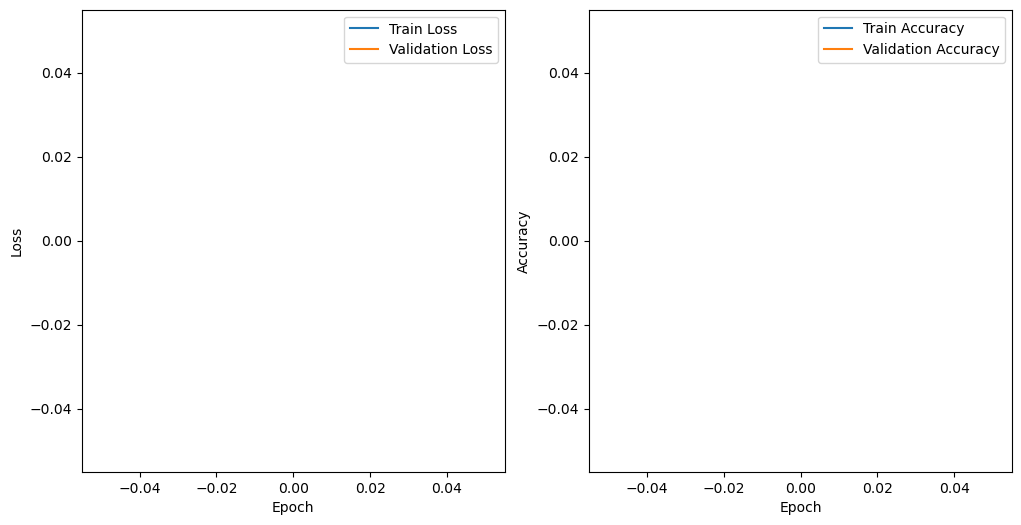

In [21]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label="Train Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label="Train Accuracy")
plt.plot(val_acc_values, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [22]:
# 모델과 토크나이저 저장
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\tokenizer.json')

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# gpu 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 테스트 데이터로 정확도 검증
model = AutoModelForSequenceClassification.from_pretrained("./saved_model")
tokenizer = AutoTokenizer.from_pretrained("./saved_model")
model.to(device)

def sentence_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
        [sent],
        return_tensors="pt",
        max_length=128,
        padding=True,
        truncation=True,
        add_special_tokens=True,
    )
    tokenized_sent = {k: v.to(device) for k, v in tokenized_sent.items()}
    with torch.no_grad():
        outputs = model(
            input_ids=tokenized_sent["input_ids"],
            attention_mask=tokenized_sent["attention_mask"],
        )
    logits = outputs[0]
    logits = logits.detach().cpu()
    result = logits.argmax(-1).numpy()[0]
    return result

data = pd.read_csv("Data/emotion3.csv")
sampled_data = data.sample(n=1000)

correct_predictions = 0

for index, row in sampled_data.iterrows():
    sentence = row['발화문']
    true_label = row['상황']
    predicted_label = sentence_predict(sentence)
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    if true_label == predicted_label:
        correct_predictions += 1

accuracy = correct_predictions / len(sampled_data)
print(f"정확도: {accuracy * 100:.2f}%")


True Label: 1, Predicted Label: 1
True Label: 2, Predicted Label: 2
True Label: 0, Predicted Label: 0
True Label: 5, Predicted Label: 5
True Label: 2, Predicted Label: 2
True Label: 5, Predicted Label: 5
True Label: 6, Predicted Label: 6
True Label: 3, Predicted Label: 3
True Label: 2, Predicted Label: 2
True Label: 6, Predicted Label: 6
True Label: 2, Predicted Label: 2
True Label: 0, Predicted Label: 0
True Label: 2, Predicted Label: 2
True Label: 0, Predicted Label: 0
True Label: 3, Predicted Label: 3
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 2, Predicted Label: 2
True Label: 5, Predicted Label: 5
True Label: 3, Predicted Label: 3
True Label: 6, Predicted Label: 6
True Label: 5, Predicted Label: 5
True Label: 6, Predicted Label: 6
True Label: 3, Predicted Label: 3
True Label: 3, Predicted Label: 3
True Label: 3, Predicted Label: 3
True Label: 1, Predicted Label: 1
True Label: 2, Predicted Label: 2
True Label: 6, Predicted Label: 6
True Label: 3,